# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

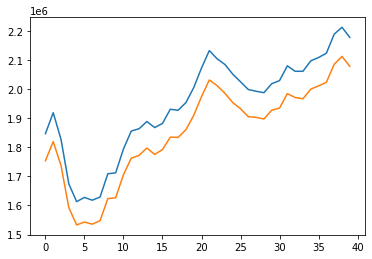

In [20]:
import pandas as pd 

df = pd.read_csv('data/births.csv')
df.loc[df['gender'] == 'M'].groupby(['year']).sum().reset_index()['births'].plot()
df.loc[df['gender'] == 'F'].groupby(['year']).sum().reset_index()['births'].plot()


# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

The residuals come on days that have special events. Busy family days see a less activity like Christmas and new year but days dedicated to relationships like valentine's day see an uptick

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

Text(0, 0.5, 'Relative number of births')

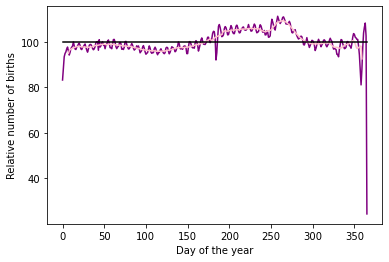

In [169]:
import seaborn as sns
df = pd.read_csv('data/births.csv')

# clean shit up
df = df.dropna()
df = df.loc[(df['day'] > 0) & (df['day'] <=31)]
df = df.loc[(df['month'] > 0 & (df['month'] <= 12))]
# force dates
df['date'] =  pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
# get day of the year
df['day_of_year'] = df['date'].dt.dayofyear

df = df.groupby(['day_of_year']).sum().reset_index()
df['births'] = df['births'] / df['births'].mean() * 100
df['mean'] = 100
# make rollig averages
rolling= df.rolling(14, center=True)
s=pd.Series([100])


ax = df['births'].plot(color='purple')
rolling.mean()['births'].plot(color="pink")
df['mean'].plot(color="black")
ax.set_xlabel("Day of the year")
ax.set_ylabel("Relative number of births")

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [179]:
import gzip
import numpy as np
import pandas as pd

# read the entire file into a Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)


In [211]:
print(f"there are {len(recipes.loc[recipes['description'].str.contains('breakfast') == True])} recipes about breakfast")

there are 3442 recipes about breakfast


### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [229]:
def recommend_ingredients(ingredients_list, df):
    
    
    for ingredient in ingredients_list:
        df[ingredient] = df['ingredients'].str.lower().str.contains(ingredient)
    remaining = df
    for ingredient in ingredients_list:
        remaining = remaining.loc[remaining[ingredient] == True]
    
    return remaining
    
print(f' there are {len(recommend_ingredients(["parsley", "paprika"], recipes))} with parsley and paprika')

 there are 11 with parsley and paprika


# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [372]:
# read the whole fucking hollywood catalogue
credit_df = pd.read_csv('data/credits.csv')

movies_metadata_df = pd.read_csv('data/movies_metadata.csv')


In [377]:

# extract the director with a regex capture group
credit_df['director'] = credit_df['crew'].str.extract("'Director', 'name': '(.*?)\',")

# prepare for inner join
credit_df['id'] = credit_df['id'].astype(str)
movies_metadata_df['id'] = movies_metadata_df['id'].astype(str)

# join
merged_inner = pd.merge(left=movies_metadata_df, right=credit_df, left_on='id', right_on='id')

# calculate and show best directors
directors_vote_average = merged_inner.groupby('director').mean().reset_index()

# removing obscure directors who made movies in their basement in black and white and shows only to their family
directors_vote_average = directors_vote_average.loc[directors_vote_average['revenue'] > 100]

print(directors_vote_average.sort_values(by=['vote_average'], ascending=False).head(100))



                   director       revenue  ...  vote_average   vote_count
8459   Josep Maria Domènech  6.215300e+04  ...      9.000000     2.000000
15630          Subodh Bhave  4.400000e+06  ...      9.000000     2.000000
7512      Jennie Livingston  3.779620e+06  ...      8.200000    67.000000
11887          Naoko Yamada  1.960662e+07  ...      8.100000   157.000000
1492                   Baik  1.080830e+05  ...      8.100000    41.000000
...                     ...           ...  ...           ...          ...
15274         Stacy Peralta  7.915000e+05  ...      7.450000    27.250000
2928            Ciro Guerra  6.600025e+05  ...      7.450000    71.500000
15976        Theodore Melfi  1.427680e+08  ...      7.450000  1474.000000
8521             Josh Boone  1.536240e+08  ...      7.450000  2262.500000
1385         Asghar Farhadi  2.172302e+06  ...      7.433333   154.666667

[100 rows x 5 columns]
